# Bibliotheken importieren

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import itertools

from helper import *

/Users/nicko/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Frage 1

**Erstellt eine Prognose der Steuererträge absolut und pro Person für die nächsten 10 Jahre unter Berücksichtigung allfälliger zyklischer Schwankungen aufgrund der historischen Steuererträge, ggf. in einer geeigneten Partition der Bevölkerung.**

## Daten einlesen und visualisieren

In [2]:
data = pd.read_csv('../Daten/Steuern_SO.csv', sep=';')
data.head()

,Jahr,Personen,Steuerbares Einkommen
0,1998,148329,6551307.0
1,1999,146773,6732949.0
2,2000,145022,6588062.0
3,2001,144154,7037941.0
4,2002,145781,7156045.0


Wir erstellen noch eine neue Spalte mit der Steuererträge pro Person.

In [3]:
data['Steuerbares Einkommen pro Person'] = round(data['Steuerbares Einkommen'] / data['Personen'],2)
data.describe()

,Jahr,Personen,Steuerbares Einkommen,Steuerbares Einkommen pro Person
count,21.000000,21.000000,2.100000e+01,21.000000
mean,2008.000000,157675.809524,7.963439e+06,50.387143
std,6.204837,11270.600541,8.973828e+05,2.701642
min,1998.000000,144154.000000,6.551307e+06,44.170000
25%,2003.000000,148329.000000,7.261471e+06,49.150000
50%,2008.000000,154909.000000,7.965942e+06,51.080000
75%,2013.000000,163634.000000,8.690159e+06,52.520000
max,2018.000000,177548.000000,9.293956e+06,54.450000


Die Daten enthalten Informationen für die Jahre 1998 bis 2018 und zeigen die Anzahl der Personen sowie das steuerbare Einkommen für jede dieser Jahre. Hier sind einige grundlegende statistische Informationen:

- Jahr: Die Daten umfassen einen Zeitraum von 21 Jahren (1998 bis 2018).

- Personen: Die Anzahl der Personen variiert im Laufe der Jahre mit einem Durchschnitt von etwa 157.676, wobei die niedrigste Anzahl bei 144.154 und die höchste bei 177.548 liegt.

- Steuerbares Einkommen: Das steuerbare Einkommen zeigt Schwankungen, mit einem durchschnittlichen Wert von etwa 7.963.439 CHF, einem Minimum von 6.551.307 CHF und einem Maximum von 9.293.956 CHF.

- Steuerbares Einkommen pro Person: Das steuerbare Einkommen pro Person zeigt ebenfalls Schwankungen, mit einem durchschnittlichen Wert von etwa 50.000 CHF, einem Minimum von 44.000 CHF und einem Maximum von 54.000 CHF.

Als nächstes sollten wir eine explorative Datenanalyse durchführen, um Trends, Muster und zyklische Schwankungen in den Daten zu identifizieren. Dies wird uns helfen, das am besten geeignete Modell für die Prognose auszuwählen. Wir können beispielsweise mit der Visualisierung der Zeitreihen für die Anzahl der Personen und das steuerbare Einkommen beginnen, um ein besseres Verständnis für die Daten zu bekommen. 

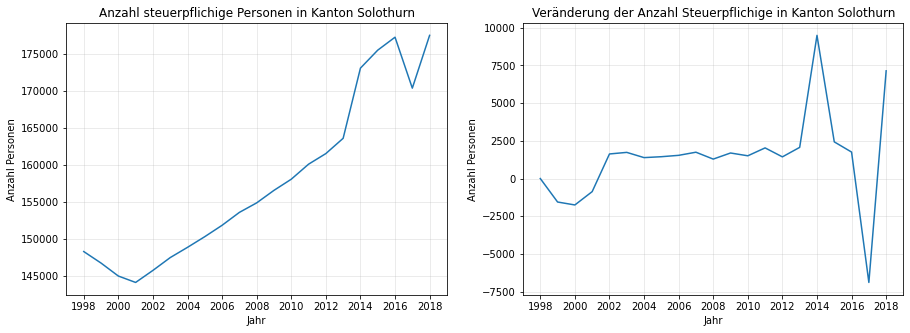

In [4]:
plot_lines(
    df=data,
    x=data['Jahr'],
    y=data['Personen'],
    title1='Anzahl steuerpflichige Personen in Kanton Solothurn',
    title2='Veränderung der Anzahl Steuerpflichige in Kanton Solothurn',
    xlabel='Jahr',
    ylabel='Anzahl Personen',
    x_ticks = data['Jahr'][::2]
)

- Es ist interessant zu sehen, dass die Anzahl steuerpflichtige Personen in Kanton Solothurn im Jahr 2017 im Vergleich zu 2016 und 2018 viel tiefer ist.

- **Alternative Fragestellung**: Wann geschieht in Kanton Solothurn das nächste Mal ein Einbruch der Anzahl Steuerpflichtige wie im Jahr 2017?

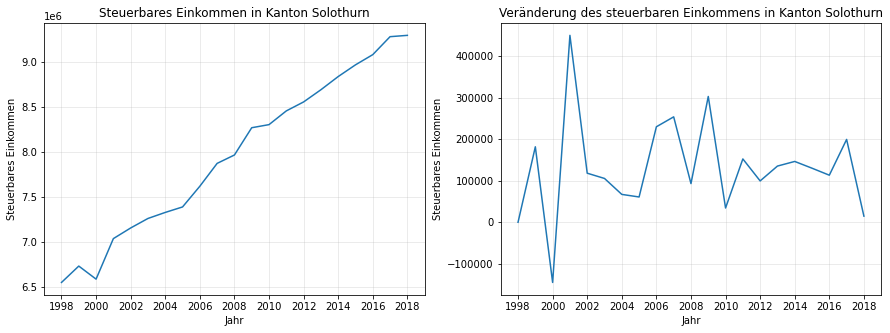

In [5]:
plot_lines(
    df=data,
    x=data['Jahr'],
    y=data['Steuerbares Einkommen'],
    title1='Steuerbares Einkommen in Kanton Solothurn',
    title2='Veränderung des steuerbaren Einkommens in Kanton Solothurn',
    xlabel='Jahr',
    ylabel='Steuerbares Einkommen',
    x_ticks = data['Jahr'][::2]
)

- Anzahl der Personen: Es scheint einen allgemeinen Aufwärtstrend in der Anzahl der Personen über den betrachteten Zeitraum zu geben, mit einigen jährlichen Schwankungen.

- Steuerbares Einkommen: Das steuerbare Einkommen zeigt ebenfalls einen Aufwärtstrend, wobei es einige Jahre gibt, in denen das Einkommen besonders hoch oder niedrig ausfällt.

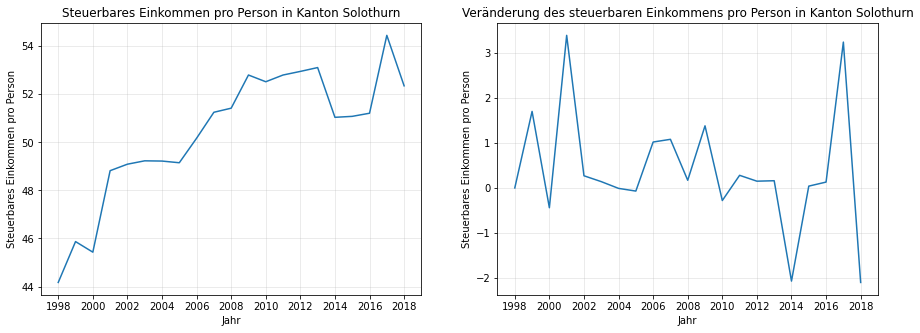

In [6]:
plot_lines(
    df=data,
    x=data['Jahr'],
    y=data['Steuerbares Einkommen pro Person'],
    title1='Steuerbares Einkommen pro Person in Kanton Solothurn',
    title2='Veränderung des steuerbaren Einkommens pro Person in Kanton Solothurn',
    xlabel='Jahr',
    ylabel='Steuerbares Einkommen pro Person',
    x_ticks = data['Jahr'][::2]
)

Für die Prognose der Steuererträge für die nächsten 10 Jahre müssen wir ein Modell auswählen, das sowohl mit Trends als auch mit zyklischen Schwankungen umgehen kann. Basierend auf diesen Beobachtungen könnten wir Modelle wie ARIMA (Autoregressive Integrated Moving Average) oder SARIMA (Seasonal ARIMA) in Betracht ziehen, die für trendabhängige Zeitreihendaten geeignet sind.

Bevor wir das Modell auswählen und trainieren, sollten wir auch überprüfen, ob es notwendig ist, die Daten zu transformieren oder zu differenzieren, um eine Stationarität zu erreichen, was ein wichtiger Schritt bei der Anwendung dieser Modelle ist.

## Test auf Stationarität

Um die Stationarität der Zeitreihendaten zu überprüfen, werden wir statistische Tests anwenden, wie z. B. den Augmented Dickey-Fuller-Test (ADF-Test), um die Nullhypothese zu überprüfen, dass die Zeitreihe eine Einheitswurzel hat und somit nicht stationär ist.

In [7]:
adf_test(data['Steuerbares Einkommen'])

Augmented Dickey-Fuller Test:
ADF-Statistik: -4.003652339081402
p-Wert: 0.0013915068209994811
Kritische Werte: {'1%': -4.137829282407408, '5%': -3.1549724074074077, '10%': -2.7144769444444443}



In [8]:
adf_test(data['Personen'])

Augmented Dickey-Fuller Test:
ADF-Statistik: 1.482978779385804
p-Wert: 0.9974603435576748
Kritische Werte: {'1%': -4.137829282407408, '5%': -3.1549724074074077, '10%': -2.7144769444444443}



In [9]:
adf_test(data['Steuerbares Einkommen pro Person'])

Augmented Dickey-Fuller Test:
ADF-Statistik: -2.499047866769448
p-Wert: 0.1157061609660267
Kritische Werte: {'1%': -3.8092091249999998, '5%': -3.0216450000000004, '10%': -2.6507125}



### Interpretation
- Für das steuerbare Einkommen ist der p-Wert niedrig (0.0014). Diese Zeitreihe ist sehr wahrscheinlich stationär.
- Für die Anzahl der Personen ist der p-Wert sehr hoch (0.9975), was bedeutet, dass wir die Nullhypothese der Nicht-Stationarität nicht ablehnen können. Die Zeitreihe ist wahrscheinlich nicht stationär.
- Für das steuerbare Einkommen pro Person ist der p-Wert 0.116, was bedeutet, dass wir die Nullhypothese der Nicht-Stationarität nicht ablehnen können. Die Zeitreihe ist wahrscheinlich nicht stationär.

### Nächste Schritte
- Für das steuerbare Einkommen scheint keine weitere Transformation notwendig zu sein, da die Zeitreihe bereits stationär zu sein scheint.
- Für die Zeitreihe der Anzahl der Personen und des steuerbaren Einkommens pro Person sollten wir eine Differenzierung oder eine andere Transformation in Betracht ziehen, um Stationarität zu erreichen.

In [10]:
# ADF-Test für die differenzierte Zeitreihe der Anzahl der Personen
adf_test(data['Personen'].diff().dropna())

Augmented Dickey-Fuller Test:
ADF-Statistik: -1.3638273013216935
p-Wert: 0.5994897315157522
Kritische Werte: {'1%': -4.223238279489106, '5%': -3.189368925619835, '10%': -2.729839421487603}



In [11]:
# ADF-Test für die differenzierte Zeitreihe der Steuerbares Einkommen pro Person
adf_test(data['Steuerbares Einkommen pro Person'].diff().dropna())

Augmented Dickey-Fuller Test:
ADF-Statistik: -5.568082269383581
p-Wert: 1.4888961236293506e-06
Kritische Werte: {'1%': -3.8326031418574136, '5%': -3.0312271701414204, '10%': -2.655519584487535}



Die Spalten scheinen auch nach der Differezierung nicht stationär zu sein. Wir werden daher eine andere Transformation in Betracht ziehen, wie z.B. die Anwendung des Logarithmus.

In [12]:
# ADF-Test für die log-transformierte Zeitreihe der Anzahl der Personen
adf_test(np.log(data['Personen']).dropna())

Augmented Dickey-Fuller Test:
ADF-Statistik: 1.5428193623203654
p-Wert: 0.9976754738561161
Kritische Werte: {'1%': -4.137829282407408, '5%': -3.1549724074074077, '10%': -2.7144769444444443}



In [13]:
# ADF-Test für die differenzierte Zeitreihe der Steuerbares Einkommen pro Person
adf_test(np.log(data['Steuerbares Einkommen pro Person']).dropna())

Augmented Dickey-Fuller Test:
ADF-Statistik: -2.626484197739592
p-Wert: 0.08764612249414261
Kritische Werte: {'1%': -3.8092091249999998, '5%': -3.0216450000000004, '10%': -2.6507125}



- Die Log Transformation der Anzahl Personen ist weiter weg von der Stationarität als die Differenzierung.

- Die Log Transformation bei der Steuererträge pro Person scheint die Stationarität knapp nicht zu erreichen. Aber es ist sicher eine bessere Annäherung der Stationarität gegenüber der Differenzierung.

In [14]:
data_log = np.log(data['Steuerbares Einkommen pro Person'])

##  Autokorrelationen

Bestimmung der ARIMA-Parameter ($p$, $d$, $q$):
- $p$: Anzahl der Lag-Observationen im Modell (Autoregression).
- $d$: Grad der Differenzierung.
- $q$: Grösse des gleitenden Durchschnittsfensters (Moving Average).

###  Steuerbares Einkommen

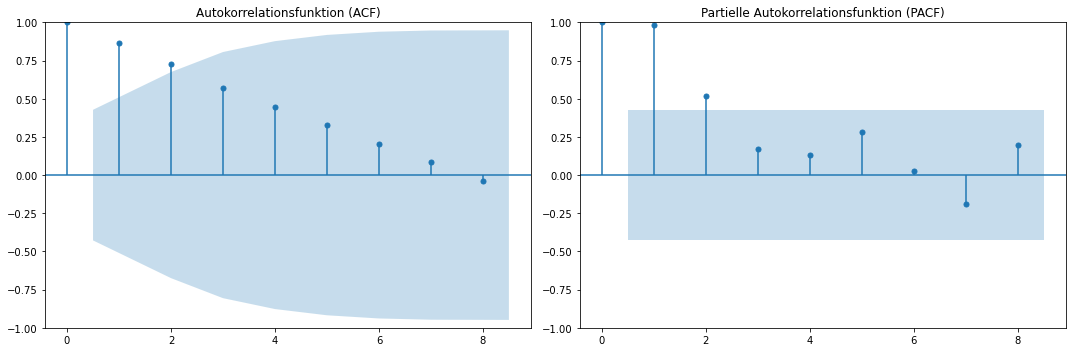

In [15]:
plot_acf_pacf(data['Steuerbares Einkommen'], lags=8)

Die ACF und PACF für die Zeitreihe des steuerbaren Einkommens wurden mit 8 Lags erfolgreich berechnet und dargestellt. Diese Plots helfen uns, die geeigneten Parameter für das ARIMA-Modell zu bestimmen:

**Parameter \( $p$ \) (AR-Teil)**: 
- Bestimmt durch die Anzahl der signifikanten Spitzen im PACF-Diagramm -> 3.
- Eine signifikante Spitze im PACF-Diagramm bei Lag \( k \) deutet darauf hin, dass \( p \) mindestens \( k \) sein könnte.

**Parameter \( $d$ \) (Differenzierung)**:
- Da wir bereits festgestellt haben, dass die Zeitreihe des steuerbaren Einkommens stationär ist, ist der Differenzierungsgrad \( d \) wahrscheinlich 0. Da wir trotzdem vorsichtig vorgehen möchten, werden wir \( d \) auf 1 setzen.

**Parameter \( $q$ \) (MA-Teil)**:
- Bestimmt durch die Anzahl der signifikanten Spitzen im ACF-Diagramm -> 3.
- Eine signifikante Spitze im ACF-Diagramm bei Lag \( k \) deutet darauf hin, dass \( q \) mindestens \( k \) sein könnte.

Parameter für das Modell: \( $p$ \) = 3, \( $d$ \) = 1, \( $q$ \) = 3

### Steuerbares Einkommen pro Jahr

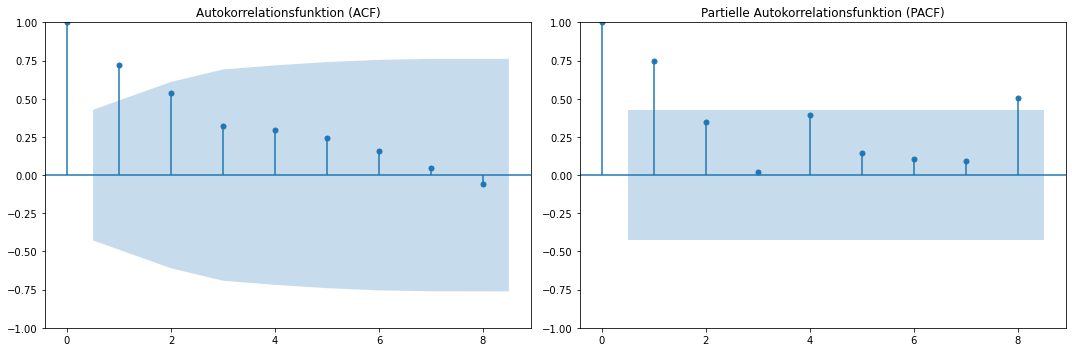

In [16]:
plot_acf_pacf(data_log, lags=8)

Wir können hier ebenfalls die Parameter für das Modell herauslesen: \( $p$ \) = 3, \( $d$ \) = 1, \( $q$ \) = 2

##  ARIMA-Modell

###  Steuerbares Einkommen

Bei Kapitel 4 haben wir die Parameter für das ARIMA-Modell aus den Plots herausgelesen. Wir haben aber auch noch eine Funktion erstellt, die uns automatisch die besten Parameter für das ARIMA-Modell basierend auf dem Akaike-Informationskriterium (AIC) bestimmt. 

Wir werden diese Funktion nun anwenden.

In [17]:
best_order, best_model = find_best_arima(data['Steuerbares Einkommen'])
print(f"Best ARIMA order: {best_order}")
print(best_model.summary())

Best ARIMA order: (2, 1, 2)
                                 SARIMAX Results                                 
Dep. Variable:     Steuerbares Einkommen   No. Observations:                   21
Model:                    ARIMA(2, 1, 2)   Log Likelihood                -257.929
Date:                   Fri, 08 Dec 2023   AIC                            525.858
Time:                           17:51:48   BIC                            530.837
Sample:                                0   HQIC                           526.830
                                    - 21                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1260      0.067      1.882      0.060      -0.005       0.257
ar.L2          0.8677      0.067     12.941      0.000       0.736       0.999


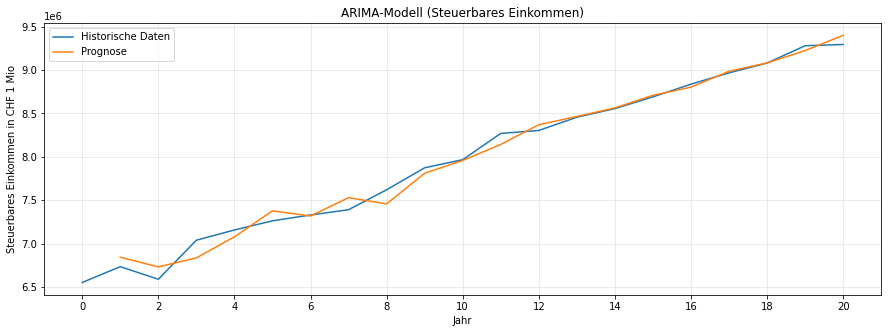

In [18]:
# Festlegen der ARIMA-Modellparameter
p, d, q = best_order

# Trainieren des ARIMA-Modells
arima_result = arima_model(data['Steuerbares Einkommen'], p, d, q)

# Plotten des ARIMA-Modells
plot_arima_model(
    data['Steuerbares Einkommen'], 
    arima_result, 
    'ARIMA-Modell (Steuerbares Einkommen)', 
    'Steuerbares Einkommen in CHF 1 Mio'
)

- Historische Daten: Dargestellt durch die blaue Linie, zeigt die tatsächlichen Werte des steuerbaren Einkommens über die Zeit.

- Prognose/Fitted Values: Dargestellt durch die orange Linie, zeigt die vom ARIMA-Modell angepassten Werte oder Prognosen, die auf den historischen Daten basieren.

Die Fitted Values werden vom ARIMA-Modell generiert und sollen so nah wie möglich an den historischen Daten liegen. Sie repräsentieren, was das Modell basierend auf seiner Struktur (den Parametern $p$, $d$ und $q$) und den ihm gegebenen Daten als den zugrunde liegenden Prozess erkennt.

Wir sehen, dass die Fitted Values die historischen Daten gut abbilden, was bedeutet, dass das Modell die Daten gut erfasst hat. Dies ist ein gutes Zeichen dafür, dass das Modell auch für die Prognose gut funktionieren sollte.

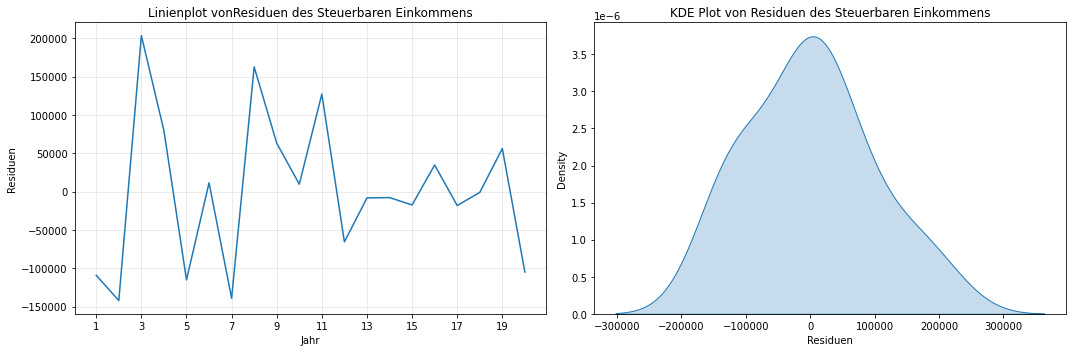

In [19]:
residuals_arima = arima_result.resid[1:]
plot_residuals(residuals_arima, 'Residuen des Steuerbaren Einkommens')

- Zeitreihendiagramm der Residuen: Hier suchen wir nach Mustern oder Trends. Idealerweise sollten die Residuen keine erkennbaren Muster aufweisen und um den Nullwert herum verteilt sein. In diesem Fall scheinen die Residuen relativ zufällig verteilt zu sein, was gut ist.

- KDE Plot der Residuen: Dieses Diagramm hilft uns zu beurteilen, ob die Residuen normalverteilt sind, was ein weiteres Zeichen für ein gut angepasstes Modell wäre. Das Histogramm zeigt eine recht symmetrische Verteilung um den Mittelwert, was darauf hindeutet, dass die Annahme der Normalverteilung der Residuen nicht verletzt wird.

###  Steuerbares Einkommen pro Person

In [20]:
best_order, best_model = find_best_arima(data_log)
print(f"Best ARIMA order: {best_order}")
print(best_model.summary())

Best ARIMA order: (0, 1, 0)
                                      SARIMAX Results                                       
Dep. Variable:     Steuerbares Einkommen pro Person   No. Observations:                   21
Model:                               ARIMA(0, 1, 0)   Log Likelihood                  43.378
Date:                              Fri, 08 Dec 2023   AIC                            -84.757
Time:                                      17:51:49   BIC                            -83.761
Sample:                                           0   HQIC                           -84.562
                                               - 21                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0008      0.000      3.983      0.000       0.000    

Die Funktion gibt uns die Parameter \( $p$ \) = 0, \( $d$ \) = 1, \( $q$ \) = 0 zurück. Wir haben unsere Analyse mit diesen Parametern durchgeführt, aber wir sind nicht auf ein gutes Modell gestossen. Wir haben daher die Parameter manuell angepasst nach unseren eigenen Einsichten aus Kapitel 4: \( $p$ \) = 3, \( $d$ \) = 1, \( $q$ \) = 2

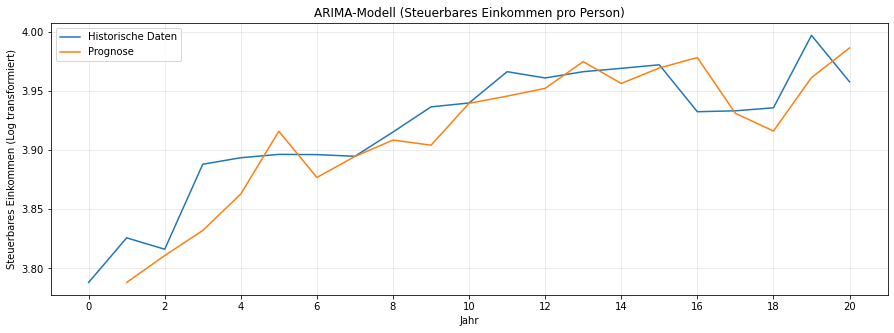

In [21]:
# Festlegen der ARIMA-Modellparameter
p, d, q = 3, 1, 2

# Trainieren des ARIMA-Modells
arima_result_2 = arima_model(data_log, p, d, q)

# Plotten des ARIMA-Modells
plot_arima_model(
    data_log,
    arima_result_2,
    'ARIMA-Modell (Steuerbares Einkommen pro Person)',
    'Steuerbares Einkommen (Log transformiert)'
)

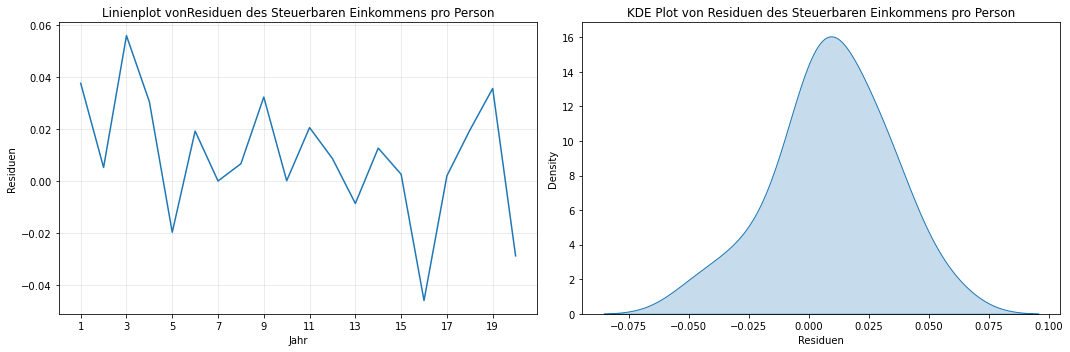

In [22]:
residuals_arima_2 = arima_result_2.resid[1:]
plot_residuals(residuals_arima_2, 'Residuen des Steuerbaren Einkommens pro Person')

##  Vorhersagen
### Steuerbares Einkommen

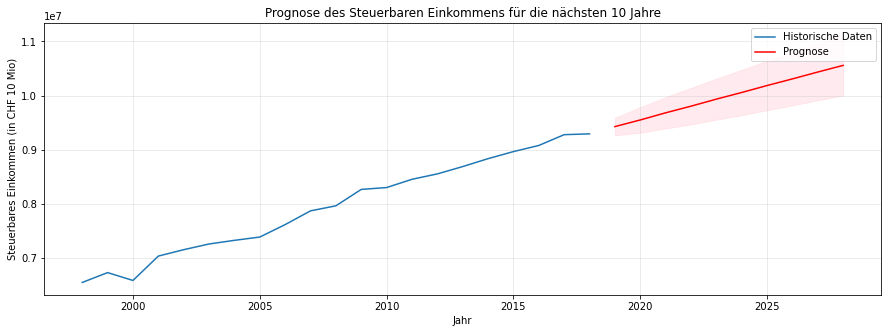

In [23]:
prognose_start, prognose_ende, prognose_mean, prognose_conf_int = get_predictions(10, arima_result, data)

# Visualisierung der Prognose zusammen mit den historischen Daten
plt.figure(figsize=(15, 5))
plt.plot(data['Jahr'], data['Steuerbares Einkommen'], label='Historische Daten')
plt.plot(range(prognose_start, prognose_ende + 1), prognose_mean, label='Prognose', color='red')
plt.fill_between(range(prognose_start, prognose_ende + 1), prognose_conf_int.iloc[:, 0], prognose_conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Prognose des Steuerbaren Einkommens für die nächsten 10 Jahre')
plt.xlabel('Jahr')
plt.ylabel('Steuerbares Einkommen (in CHF 10 Mio)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

Die Prognose des steuerbaren Einkommens für die nächsten 10 Jahre wurde erfolgreich erstellt und ist im obigen Diagramm dargestellt. In der Grafik sieht man:

- Historische Daten: Die blaue Linie zeigt das steuerbare Einkommen der vergangenen Jahre.

- Prognose: Die rote Linie repräsentiert die prognostizierten Werte des steuerbaren Einkommens für die nächsten 10 Jahre.

- Konfidenzintervall: Der rosafarbene Bereich zeigt das 95% Konfidenzintervall der Prognose. Dies gibt den Bereich an, in dem die tatsächlichen Werte mit einer Wahrscheinlichkeit von 95% liegen sollten.

###  Steuerbares Einkommen pro Person

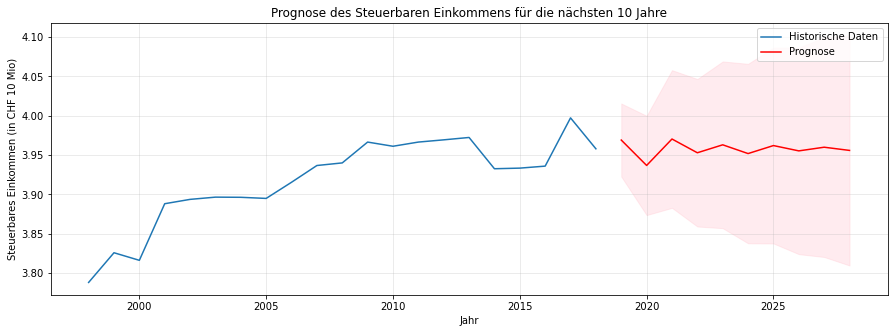

In [24]:
prognose_start, prognose_ende, prognose_mean, prognose_conf_int = get_predictions(10, arima_result_2, data)

# Visualisierung der Prognose zusammen mit den historischen Daten
plt.figure(figsize=(15, 5))
plt.plot(data['Jahr'], np.log(data['Steuerbares Einkommen pro Person']).dropna(), label='Historische Daten')
plt.plot(range(prognose_start, prognose_ende + 1), prognose_mean, label='Prognose', color='red')
plt.fill_between(range(prognose_start, prognose_ende + 1), prognose_conf_int.iloc[:, 0], prognose_conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Prognose des Steuerbaren Einkommens für die nächsten 10 Jahre')
plt.xlabel('Jahr')
plt.ylabel('Steuerbares Einkommen (in CHF 10 Mio)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

##  Extremwertanalyse

Die Extremwertanalyse ist ein statistischer Ansatz, um die Verteilung von Werten am äussersten Ende des Spektrums zu untersuchen, was besonders wichtig ist, wenn man sich für das Risiko von seltenen Ereignissen interessiert, wie z.B. in der Finanzrisikoanalyse oder bei der Bewertung von Naturkatastrophen.

###  Shapiro Wilk Test
Dieser Test überprüft die Nullhypothese, dass die Daten einer Normalverteilung folgen. Ein hoher p-Wert (typischerweise > 0.05) deutet darauf hin, dass die Daten nicht signifikant von der Normalverteilung abweichen.

In [25]:
shapiro_test(residuals_arima)

{'Wert': 0.9574923515319824,
 'p-Wert': 0.4950511157512665,
 'Interpretation': 'Normalverteilt'}

In [26]:
shapiro_test(residuals_arima_2)

{'Wert': 0.9773672819137573,
 'p-Wert': 0.8957728743553162,
 'Interpretation': 'Normalverteilt'}

### Histogramm und Normalverteilung

Ein Histogramm zeigt die Häufigkeitsverteilung der Residuen. Die Überlagerung der Wahrscheinlichkeitsdichtefunktion einer Normalverteilung gibt an, wie gut die Residuen dieser Verteilung folgen.

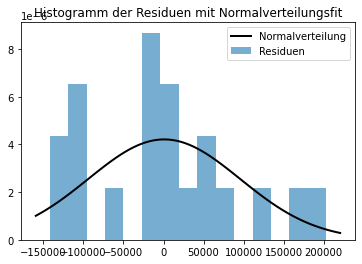

In [27]:
# Histogramm der Residuen des Steuerbaren Einkommens
plot_residuals_histogram(residuals_arima, 15)

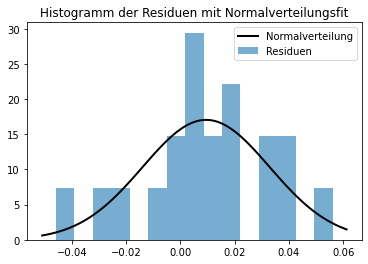

In [28]:
# Histogramm der Residuen des Steuerbaren Einkommens pro Person
plot_residuals_histogram(residuals_arima_2, 15)

### Kumulative Verteilungsfunktion (CDF)

Sie vergleicht die empirische kumulative Verteilungsfunktion der Residuen mit der kumulativen Verteilungsfunktion einer Normalverteilung. Die Residuen sollten der Normalverteilung folgen, wenn die Punkte auf der diagonalen Linie liegen.

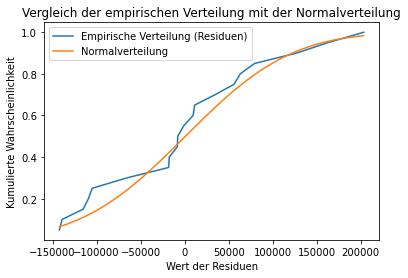

In [29]:
# ECDF der Residuen von Steuerbares Einkommen
plot_residuals_ecdf(residuals_arima)

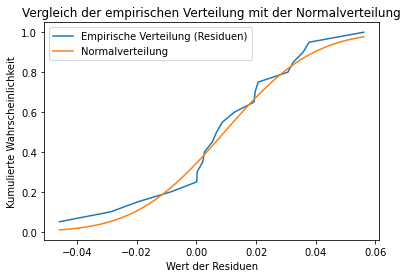

In [30]:
# ECDF der Residuen von Steuerbares Einkommen pro Person
plot_residuals_ecdf(residuals_arima_2)

###  QQ Plot

Ein Q-Q-Plot stellt die Quantile der Residuenverteilung denen einer Normalverteilung gegenüber. Die Residuenverteilung ist normalverteilt, wenn die Punkte auf einer geraden Linie liegen.

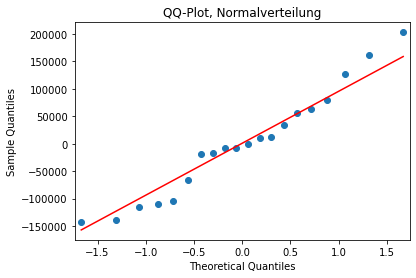

In [31]:
# QQ-Plot der Residuen von Steuerbares Einkommen
plot_qq(residuals_arima)

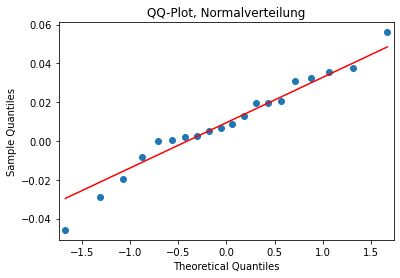

In [32]:
# QQ-Plot der Residuen von Steuerbares Einkommen pro Person
plot_qq(residuals_arima_2)

# Frage 2

**Bestimmt, wie stark BIP- und Demographiezahlen als vorlaufende Indikatoren verwendbar sind, wie viele Jahre Vorlauf sie Euch gewähren.**

## Einlesen notwendiger Daten

In [34]:
bip_df = pd.read_csv('../Daten/BIP_SO.csv', sep=';')
bev_df = pd.read_csv('../Daten/Bevölkerung_SO_Neu.csv', sep=';')
# copy data to steuern_df
steuern_df = data.copy()

## Daten richtig Formatieren

In [35]:
# convert Jahr to datetime Jahr
steuern_df['Jahr'] = pd.to_datetime(steuern_df['Jahr'], format='%Y')
bip_df['Jahr'] = pd.to_datetime(bip_df['Jahr'], format='%Y')

In [36]:
bev_df['Jahr'] = pd.to_datetime(bev_df['Datum']).dt.year
# change column Datum to Jahr
# reomve column Datum
bev_df['Jahr'] = pd.to_datetime(bev_df['Jahr'], format='%Y')
bev_df = bev_df.drop(columns=['Datum'])

## Zusammenführen der Datensätze

In [38]:
# merge dataframes on column Jahr
df = steuern_df.merge(bev_df, on='Jahr')
df = df.merge(bip_df, on='Jahr')
df

,Jahr,Personen,Steuerbares Einkommen,Steuerbares Einkommen pro Person,KT_SO,Sonnenberg,BIP_SO,BIP_NWCH,BIP_CH
0,2008-01-01,154909,7965942.000,51.42,254444,5026,16764.66925,88564.12220,614407.7193
1,2009-01-01,156600,8268712.000,52.80,255667,5126,16119.66708,86806.37570,603039.0736
2,2010-01-01,158106,8303010.000,52.52,256888,5124,16640.00445,88476.87018,624545.1186
3,2011-01-01,160135,8455432.000,52.80,257393,5251,16917.99754,90486.47250,635738.7442
4,2012-01-01,161570,8554928.954,52.95,259836,5065,17011.32618,90232.37095,643645.5891
5,2013-01-01,163634,8690159.406,53.11,262965,5306,17296.25571,91795.05271,654611.6690
6,2014-01-01,173118,8836526.631,51.04,265171,5516,17571.80308,93901.84257,665618.3745
7,2015-01-01,175546,8966626.422,51.08,267836,5512,17665.54196,94684.33401,668006.3817
8,2016-01-01,177298,9079906.635,51.21,270711,5620,17665.91637,97771.48251,677848.3306
9,2017-01-01,170414,9279286.000,54.45,273015,5662,17888.23339,100363.65720,684558.4675


ADF Statistic: 2.844975
p-value: 1.000000
Critical Values:
	1%: -5.354
	5%: -3.646
	10%: -2.901
ADF Statistic: 1.728955
p-value: 0.998197
Critical Values:
	1%: -6.045
	5%: -3.929
	10%: -2.987
ADF Statistic: -0.302476
p-value: 0.925153
Critical Values:
	1%: -6.045
	5%: -3.929
	10%: -2.987
Best SARIMAX(0, 0, 0)x(0, 1, 0, 12) AIC:6.0


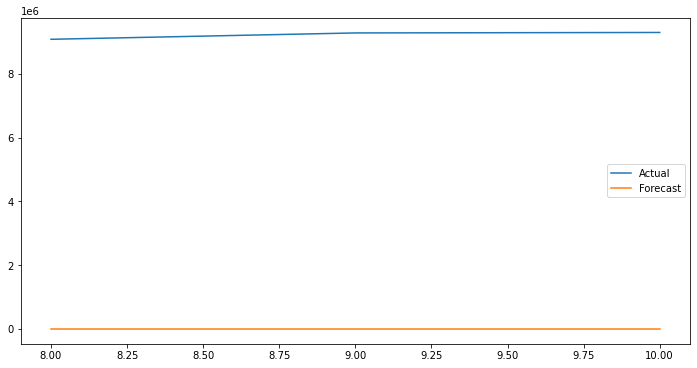

Mean Absolute Error (MAE): 9217716.228333334
Mean Squared Error (MSE): 84975824076481.55
Root Mean Squared Error (RMSE): 9218233.240512064


In [39]:
# Define target and predictors
y = df['Steuerbares Einkommen']
X = df[['Personen', 'BIP_SO']]

# Split data into train and test sets
# Example: 80% train, 20% test
split_idx = int(len(df) * 0.8)
train_y, test_y = y[:split_idx], y[split_idx:]
train_X, test_X = X[:split_idx], X[split_idx:]

def check_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    return result  # Return the full result

# Stationarity checks for both target and predictors
adf_result_y = check_stationarity(train_y)
adf_result_X = [check_stationarity(train_X[col]) for col in train_X.columns]

# If not stationary, difference the data
if adf_result_y[1] > 0.05:
    train_y = train_y.diff().dropna()
    
train_X = train_X.diff().dropna()

# Define the p, d, q combinations to try
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]  # Assuming yearly seasonality

best_aic = np.inf
best_model = None
best_params = None
best_seasonal_params = None

# Grid Search
for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            temp_model = SARIMAX(train_y,
                                 exog=train_X,
                                 order=param,
                                 seasonal_order=seasonal_param,
                                 enforce_stationarity=False,
                                 enforce_invertibility=False)
            results = temp_model.fit(disp=False)

            if results.aic < best_aic:
                best_aic = results.aic
                best_params = param
                best_seasonal_params = seasonal_param
                best_model = results

        except Exception as e:
            continue

print(f'Best SARIMAX{best_params}x{best_seasonal_params} AIC:{best_aic}')

# Forecast
forecast = best_model.get_forecast(steps=len(test_y), exog=test_X)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot the forecast against the actual outcomes
plt.figure(figsize=(12, 6))
plt.plot(test_y.index, test_y, label='Actual')
plt.plot(test_y.index, forecast_mean, label='Forecast')
plt.fill_between(test_y.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.show()

# Calculate error metrics
mse = mean_squared_error(test_y, forecast_mean)
mae = mean_absolute_error(test_y, forecast_mean)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Frage 3

**Berechnet, welches Steuerloch im schlechtesten Fall und welcher Überschuss im besten
Fall alle 50 Jahre bei den natürlichen Personen zu erwarten sind.**

Um das "Steuerloch" im schlechtesten Fall und den "Überschuss" im besten Fall über einen Zeitraum von 50 Jahren für natürliche Personen zu berechnen, fehlen uns noch spezifische Annahmen oder Modelle. Jedoch kann ich Ihnen einen generellen Ansatz bieten, der auf der Extrapolation der historischen Daten basiert.

Ich werde ein einfaches Prognosemodell verwenden, das auf Ihrem bestehenden SARIMAX-Modell aufbaut. Wir werden dabei annehmen, dass die bisherigen Trends sich fortsetzen. Für das schlechteste und das beste Szenario könnten wir die historische Varianz der Einkommensdaten verwenden, um eine Bandbreite möglicher zukünftiger Werte zu schätzen.

Zuerst werden wir das Modell mit allen verfügbaren Daten trainieren und dann Prognosen für die nächsten 50 Jahre machen. Dann berechnen wir für jedes Jahr die untere und obere Schätzung, basierend auf der historischen Varianz der "Steuerbares Einkommen" Daten.

Hier ist der angepasste Code:

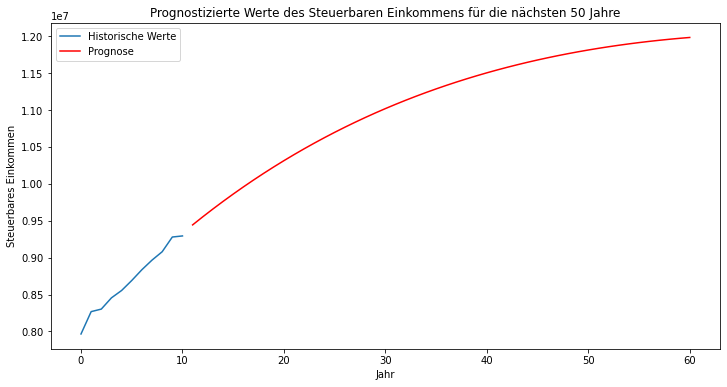

In [40]:


# Angenommen, df ist Ihr DataFrame und ist bereits korrekt formatiert

# Definieren von Zielvariable und Prädiktoren
y = df['Steuerbares Einkommen']
X = df[['Personen', 'BIP_SO']]

# Training des Modells mit allen verfügbaren Daten
model = SARIMAX(y, exog=X, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
model_fit = model.fit(disp=False)

# Annahmen für die zukünftigen Werte von 'Personen' und 'BIP_SO'
# Ersetzen Sie dies durch Ihre eigenen Annahmen oder Schätzmodelle
future_periods = 50
future_personen = np.linspace(X['Personen'].iloc[-1], X['Personen'].iloc[-1] * 1.2, future_periods)
future_bip_so = np.linspace(X['BIP_SO'].iloc[-1], X['BIP_SO'].iloc[-1] * 1.5, future_periods)

# Erstellen eines DataFrame für die zukünftigen exogenen Variablen
future_X = pd.DataFrame({'Personen': future_personen, 'BIP_SO': future_bip_so})

# Überprüfen und Anpassen des letzten Indexwertes
last_index_value = y.index[-1]
if not isinstance(last_index_value, pd.Timestamp):
    # Konvertieren in pd.Timestamp, falls es kein Datum ist
    last_index_value = pd.to_datetime(last_index_value, format='%Y-%m-%d')

# Erstellen des zukünftigen Datumsindex
future_index = pd.date_range(start=last_index_value + pd.DateOffset(years=1), periods=future_periods, freq='YS')
future_X.index = future_index

# Prognose für die nächsten 50 Jahre
predictions = model_fit.get_forecast(steps=future_periods, exog=future_X)
predicted_mean = predictions.predicted_mean

# Anzeigen der Ergebnisse
plt.figure(figsize=(12, 6))
plt.plot(y.index, y, label='Historische Werte')
plt.plot(predicted_mean.index, predicted_mean, label='Prognose', color='red')
plt.title('Prognostizierte Werte des Steuerbaren Einkommens für die nächsten 50 Jahre')
plt.xlabel('Jahr')
plt.ylabel('Steuerbares Einkommen')
plt.legend()
plt.show()